# Simple Convolutional Autoencoder

## Imports and definitions

### Model Class and Loss Function Definitions

In [1]:
# %load sconce/models/basic_convolutional_autoencoder.py
from torch import nn
from torch.nn import functional as F
from sconce.models.layers import Convolution2dLayer, Deconvolution2dLayer


class BasicConvolutionalAutoencoder(nn.Module):
    """
    A basic 2D image autoencoder built up of convolutional layers, three each in the encoder and the decoder.

    Loss:
        This model uses binary cross-entropy for the loss.

    Metrics:
        None

    Arguments:
        image_channels (int): the number of channels in the input images.
        conv_channels (list of int): a list of length three of integers describing the number of channels in each of the
            three convolutional layers.
    """
    def __init__(self, image_channels, conv_channels):
        super().__init__()
        self.conv1 = Convolution2dLayer(
                in_channels=image_channels,
                out_channels=conv_channels[0])

        self.conv2 = Convolution2dLayer(
                in_channels=conv_channels[0],
                out_channels=conv_channels[1])

        self.conv3 = Convolution2dLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[2],
                padding=2)

        self.deconv1 = Deconvolution2dLayer(
                in_channels=conv_channels[2],
                out_channels=conv_channels[1],
                padding=2,
                output_padding=0)

        self.deconv2 = Deconvolution2dLayer(
                in_channels=conv_channels[1],
                out_channels=conv_channels[0])

        self.deconv3 = Deconvolution2dLayer(
                in_channels=conv_channels[0],
                out_channels=image_channels,
                preactivate=True)


    def encode(self, x_in, **kwargs):
        x = self.conv1(x_in)
        x = self.conv2(x)
        x_latent = self.conv3(x)
        return x_latent

    def decode(self, x_latent):
        x = self.deconv1(x_latent)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x_out = nn.Sigmoid()(x)
        return x_out

    def forward(self, inputs, **kwargs):
        x_latent = self.encode(inputs)
        x_out = self.decode(x_latent)
        return {'outputs': x_out}

    def calculate_loss(self, inputs, outputs, **kwargs):
        reconstruction_loss = F.binary_cross_entropy(outputs,
                inputs.view_as(outputs))
        return {'loss': reconstruction_loss}


## DataGenerators

In [2]:
from sconce.data_generators import ImageDataGenerator

kwargs = {
    'batch_size': 500,
    'num_workers': 2,
    'pin_memory': True,
    'shuffle': True
}

training_generator = ImageDataGenerator.from_torchvision(**kwargs)
test_generator = ImageDataGenerator.from_torchvision(train=False, **kwargs)

## Trainer

In [3]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer

def get_trainer(conv_channels=[2, 2, 2], momentum=0.9, weight_decay=1e-4):
    model = BasicConvolutionalAutoencoder(image_channels=1, conv_channels=conv_channels)
    
    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()
        
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    trainer = AutoencoderTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

## Results

### Constricted Bottleneck

In [4]:
trainer = get_trainer(conv_channels=[4, 8, 2])
trainer.num_trainable_parameters

1017

205/240 [========================>.....] - ETA: 2s - loss: 0.4546

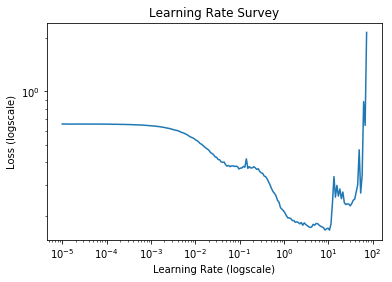

In [5]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=2,
    min_learning_rate=1e-5,
    max_learning_rate=1e3,
    stop_factor=10)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [6]:
from sconce.rate_controllers import TriangleRateController
rate_controller = TriangleRateController(max_learning_rate=1, min_learning_rate=0.01)
trainer.train(num_epochs=5, rate_controller=rate_controller)

600/600 [==============================] - 35s 59ms/step - loss: 0.1722 - val_loss: 0.1744


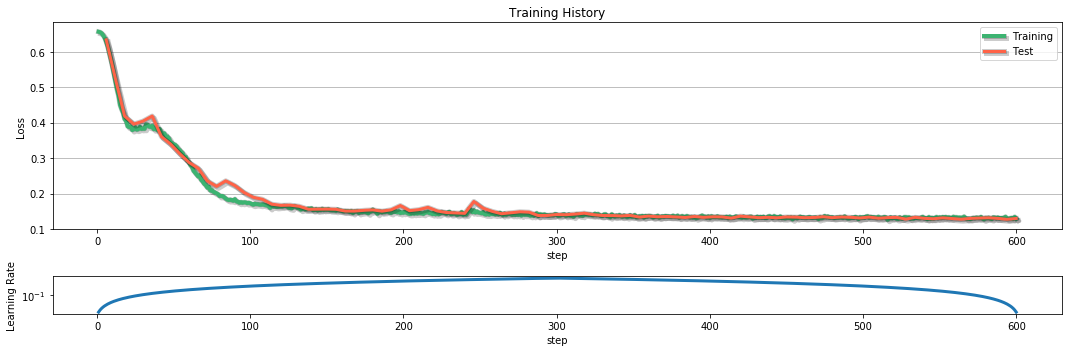

In [7]:
trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0);

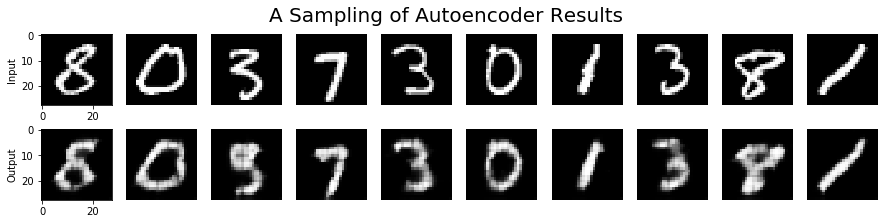

In [8]:
trainer.plot_input_output_pairs();

In [9]:
test_monitor = trainer.test()
test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
print(f'Final Test Loss: {test_loss: 0.3e}')

120/120 [==============================] - 2s 17ms/step - loss: 0.1297
Final Test Loss:  1.297e-01


### Relaxed Bottleneck

In [10]:
def train_convolutional_ae(conv_channels):
    trainer = get_trainer(conv_channels=conv_channels)
    trainer.train(num_epochs=5, rate_controller=rate_controller)
    test_monitor = trainer.test()
    test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
    print(f'Final Test Loss: {test_loss: 0.3e}')
    print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')
    trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0)
    trainer.plot_input_output_pairs()

120/120 [==============================] - 2s 17ms/step - loss: 0.0944
Final Test Loss:  9.438e-02
Number of trainable parameters: 1311


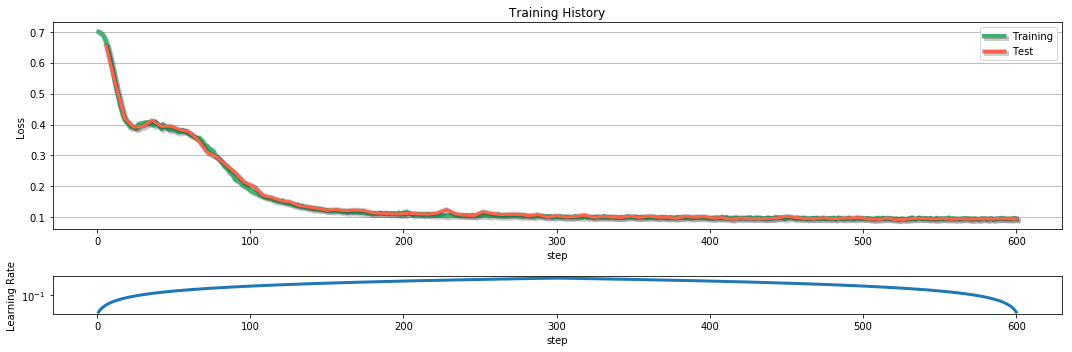

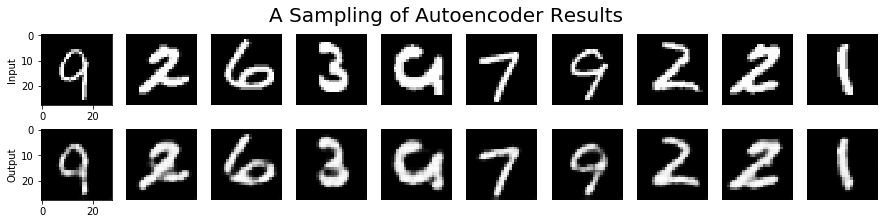

In [11]:
train_convolutional_ae(conv_channels=[4, 8, 4])

120/120 [==============================] - 2s 17ms/step - loss: 0.0695
Final Test Loss:  6.947e-02
Number of trainable parameters: 3075


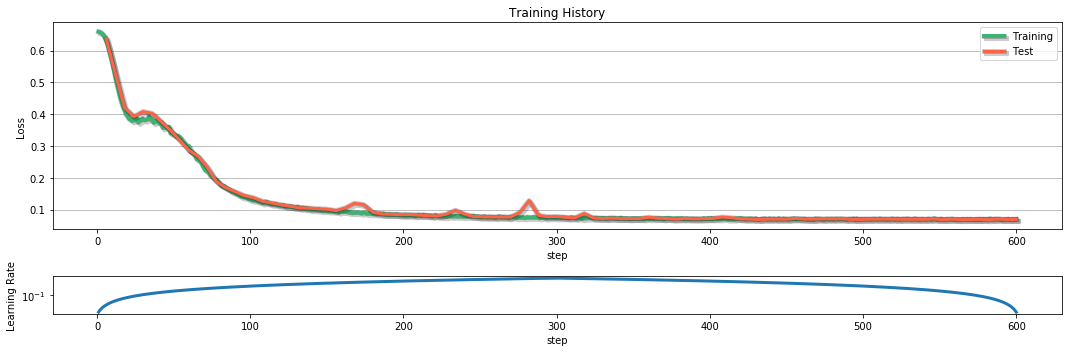

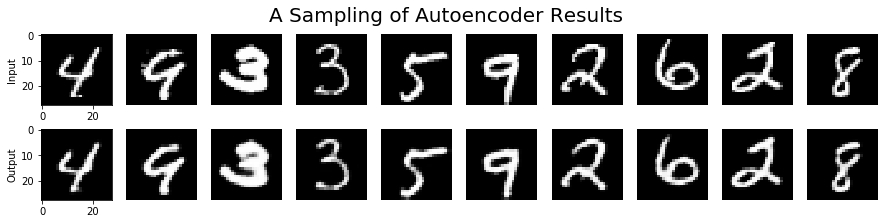

In [12]:
train_convolutional_ae(conv_channels=[4, 8, 16])